### - Sobhan Moradian Daghigh
#### - 7/3/2022
### - DIP - HW04 - Q4

In [1]:
import numpy as np
import glob
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
import random

In [2]:
def load_datas(folder_name):
    images = glob.glob('{}*.png'.format(folder_name))
    datas = []
    names = []
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        datas.append(img)
        names.append(image.split('\\')[-1][:-4])
    return datas, names

In [65]:
images, names = load_datas('./inputs/P4/')

In [66]:
names

['kobytev_1941', 'kobytev_1945', 'reference_keypoints']

In [67]:
def plotter(images, names=None, subplots=None, gray=False):
    if subplots is None:
        plt.figure(figsize=(5, 6))
        plt.imshow(images, cmap='gray') if gray else plt.imshow(images)
        plt.title(names)
        plt.axis('off')
    else:
        fig, ax = plt.subplots(subplots[0], subplots[1], figsize=(subplots[1] * 5, subplots[0] * 6))
        for i, (img, name, ax) in enumerate(zip(images, names, fig.axes)):
            ax.imshow(img, cmap='gray') if gray else ax.imshow(img)
            ax.set_title(name)
            ax.axis('off')
    plt.show()

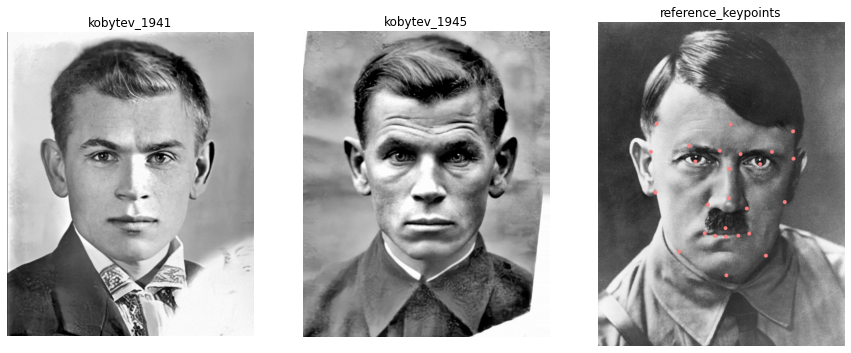

In [68]:
plotter(images, names, subplots=(1, 3))

In [69]:
images[0].shape, images[1].shape

((956, 774, 3), (956, 771, 3))

In [70]:
blank = np.zeros(images[0].shape, dtype=np.uint8)
blank[:images[1].shape[0], :images[1].shape[1]] = images[1]
images[1] = blank
images[0].shape, images[1].shape

((956, 774, 3), (956, 774, 3))

### Part A.
Naïve Method

In [122]:
def naive_method(img1, img2, cnt):
    results = []
    names = []
    for alpha in np.linspace(0, 1, cnt):
        alpha = round(alpha, 1)
        naive_res = cv2.addWeighted(img1, 1 - alpha, img2, alpha, 0)
        results.append(naive_res)
        names.append('({} * img1) + ({} * img2)'.format(alpha, round(1 - alpha, 1)))
    return results, names

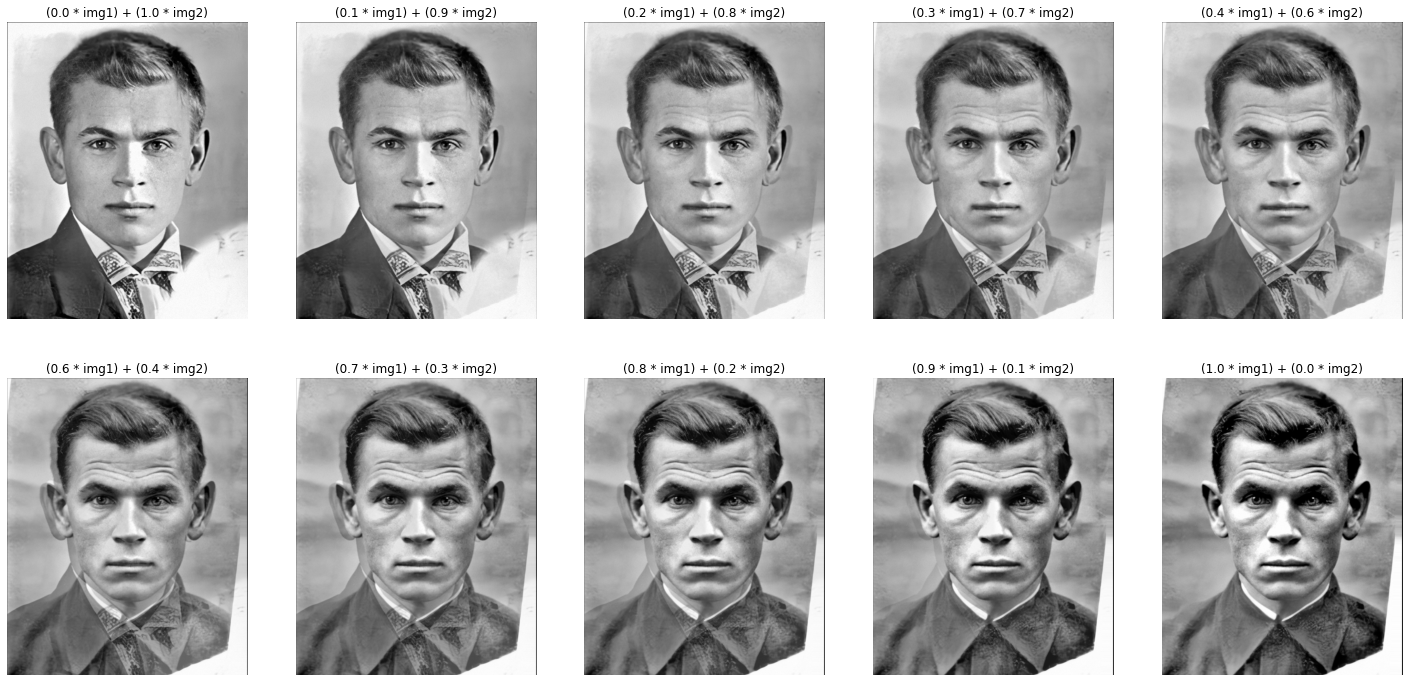

In [123]:
naive_results, naive_names = naive_method(images[0], images[1], 10)
plotter(naive_results, naive_names, subplots=(2, 5))

### Part B.
keypoints

In [73]:
def mouse_click(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        param[1].append([x, y])
        cv2.destroyWindow("Choose")
        param[0] = point_putter(param[0], param[1])
        coordinates_selector(param[0], '', param[1])

In [74]:
def coordinates_selector(img, img_name, points):
    cv2.imshow('Choose', img)
    cv2.setMouseCallback('Choose', mouse_click, [img, points])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return img

In [75]:
def point_putter(img, points):
    for point in points:
        w_size = 3
        i, j = point[1], point[0]
        cv2.circle(img, point, 5, (255, 0, 0), -1)
    return img

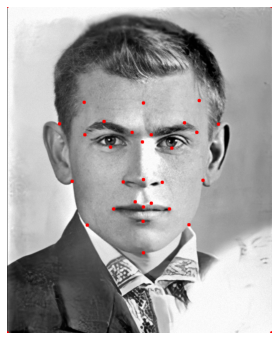

In [115]:
points1 = []
coordinates_selector(images[0].copy(), names[0], points1)
points1.extend([[0, 0], [0, images[0].shape[0] - 1], [images[0].shape[1] - 1, 0], [images[0].shape[1] - 1, images[0].shape[0] - 1]])
plotter(point_putter(images[0].copy(), points1))

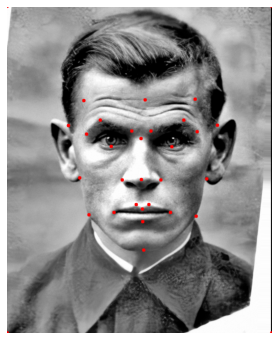

In [120]:
points2 = []
coordinates_selector(images[1].copy(), names[1], points2)
points2.extend([[0, 0], [0, images[1].shape[0] - 1], [images[1].shape[1] - 1, 0], [images[1].shape[1] - 1, images[1].shape[0] - 1]])
plotter(point_putter(images[1].copy(), points2))

### Part C.
triangulation

In [108]:
'''
Source: [https://learnopencv.com/delaunay-triangulation-and-voronoi-diagram-using-opencv-c-python/]
'''

# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Draw a point
def draw_point(img, p, color) :
    cv2.circle(img, p, 5, color, -1)


# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color):
    
    triangleList = subdiv.getTriangleList().astype(np.int32)
    size = img.shape
    r = (0, 0, size[1], size[0])

    for t in triangleList:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :

            cv2.line(img, pt1, pt2, delaunay_color, 2, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 2, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 2, cv2.LINE_AA, 0)

In [111]:
def delaunay_triangulation(img, points):
    size = img.shape
    rect = (0, 0, size[1], size[0])

    # Create an instance of Subdiv2D
    subdiv = cv2.Subdiv2D(rect)

    # Insert points into subdiv
    for p in points:
        subdiv.insert(p)

    # Draw delaunay triangles
    draw_delaunay(img, subdiv, (158, 255, 180))

    # Draw points
    for p in points :
        draw_point(img, p, (255, 0, 0))

    # Show results
    plotter(img)

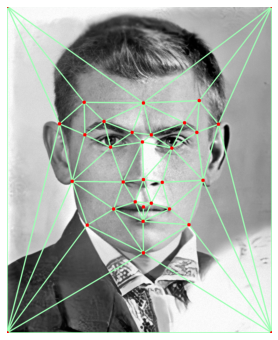

In [116]:
delaunay_triangulation(images[0].copy(), points1)

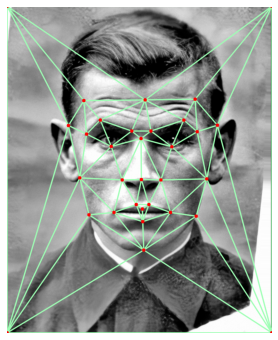

In [121]:
delaunay_triangulation(images[1].copy(), points2)